# Human Segmentation w/ RAGUNet

ABSTRACT:

Low-shot human segmentation is an ongoing challenge in computer vision. The current SoTA for general segmentation are ViTs, but transformers suffer in low training data environments. It has been shown that the U-Net CNN performs remarkably well in general for low-shot segmentation tasks, but can suffer by  design. U-Nets are naturally deep networks, which tend to overfit on small training sets. Additionally, the long-skip connections from the encoder to the decoder pass contextual information, which is potentially noisy, to the decoder, which can harm the upsampling process. To alleviate this, we propose a custom Residual Attention Gated U-Net, or RAGUNet, which uses residual short-skip connection blocks to help the U-Net converge faster with improved gradient flow, as well as an Attention Gate module, which simultaneously highlights the salient features from the encoder's long-skip connections while suppressing background noise. Our results indicate smoother and quicker convergence graphs than typical U-Net architectures, with strong segmentation performance.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random

from google.colab import drive
import sys
import os
from PIL import Image

# Global Path Variables
IMAGE_DIR = "Image Data"
MASK_DIR = "Mask Data"

# Initialize random seed
random.seed(417)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# The following command loads up your google drive.
drive.mount('/content/drive')

FOLDERNAME = "PHYS 417/Final Project"
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd /content/drive/My\ Drive/$FOLDERNAME
%matplotlib inline

Mounted at /content/drive
/content/drive/My Drive/PHYS 417/Final Project


## Data Preprocessing

First, it's important to figure out what our data looks like in terms of dimensions. We need them to all be the same size. Let's plot a histogram of data widths and heights, and make an educated assessment from there.

In [2]:
### Uncomment Below for Image Statistics

# widths = []
# heights = []

# # Collect image data
# for fname in os.listdir(IMAGE_DIR):
#     if fname.lower().endswith(".jpg"):
#         path = os.path.join(IMAGE_DIR, fname)
#         with Image.open(path) as img:
#             w, h = img.size
#             widths.append(w)
#             heights.append(h)


# # Convert to NumPy arrays for stats
# widths_np = np.array(widths)
# heights_np = np.array(heights)

# # Print mean and median
# print(f"Width - Mean: {widths_np.mean():.2f}, Median: {np.median(widths_np)}")
# print(f"Height - Mean: {heights_np.mean():.2f}, Median: {np.median(heights_np)}")

# # Plot histograms
# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.hist(widths, bins=20, color='skyblue', edgecolor='black')
# plt.title('Image Widths')
# plt.xlabel('Width (pixels)')
# plt.ylabel('Frequency')

# plt.subplot(1, 2, 2)
# plt.hist(heights, bins=20, color='salmon', edgecolor='black')
# plt.title('Image Heights')
# plt.xlabel('Height (pixels)')
# plt.ylabel('Frequency')

# plt.tight_layout()
# plt.show()


Given the above stats, we will rescale all images to align with 512 x 512 image standards to ensure consistency across the board.

Let's write a function to pull the image and mask data into a PyTorch Dataset and ensure the files are linked. First, we resize images to 512 x 512. Then, we randomly apply some augments to each base image $N$ times to help expand our dataset further. Potential augmentations include:
- Horizontal flip
- Random rotation
- Random resize & crop
- Random affine transformations
- Color jitter

In [3]:
# Number of augmented images for training dataset
NUM_AUGMENTED_IMAGES = 4

class AugmentedSegmentationDataset(Dataset):
    def __init__(self, image_filenames, output_size=(512, 512), augment=False):
        self.image_dir = IMAGE_DIR
        self.mask_dir = MASK_DIR
        self.output_size = output_size
        self.augment = augment

        # Possible transforms to be randomly selected at runtime
        self.spatial_pool = [
            transforms.RandomHorizontalFlip(p=1.0),
            transforms.RandomRotation(degrees=30),
            transforms.RandomAffine(degrees=(-20, 20), translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
            transforms.RandomResizedCrop(output_size, scale=(0.7, 1.0), ratio=(0.67, 1.33)),
        ]

        # Color jitter adapter (to be applied randomly at runtime)
        self.color_jitter = transforms.ColorJitter(
            brightness=0.4, contrast=0.4, saturation=0.4, hue=0.04
        )

        # Use provided list of filenames (subset)
        self.image_filenames = sorted(image_filenames)

        # Corresponding mask filenames assumed same names but .png extension
        self.mask_filenames = [f.replace('.jpg', '.png') for f in self.image_filenames]

        assert len(self.image_filenames) == len(self.mask_filenames), "Mismatched number of images and masks"

        # Transforms to:
        # - Resize to 512 x 512
        # - Form tensor object
        self.base_resize = transforms.Resize(output_size)
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        def rand_augment(image, mask):
            image_copy = image.copy()
            mask_copy = mask.copy()

            if self.augment:
                # Sample 1-2 random spatial transforms
                num_transforms = random.choice([1, 2])
                chosen_transforms = random.sample(self.spatial_pool, num_transforms)

                for transform in chosen_transforms:
                    # Apply the exact same transform params to image and mask
                    if isinstance(transform, transforms.RandomHorizontalFlip):
                        # p=1.0 means always flip
                        image_copy = TF.hflip(image_copy)
                        mask_copy = TF.hflip(mask_copy)

                    elif isinstance(transform, transforms.RandomRotation):
                        # Access the degree range from the list attribute
                        angle = random.uniform(transform.degrees[0], transform.degrees[1])
                        image_copy = TF.rotate(image_copy, angle)
                        mask_copy = TF.rotate(mask_copy, angle)

                    elif isinstance(transform, transforms.RandomAffine):
                         # Handle degrees range safely
                        if isinstance(transform.degrees, (tuple, list)):
                            angle = random.uniform(transform.degrees[0], transform.degrees[1])
                        else:
                            angle = random.uniform(-transform.degrees, transform.degrees)

                        # Sample parameters explicitly:
                        translate_x = random.uniform(-transform.translate[0], transform.translate[0]) * image_copy.width
                        translate_y = random.uniform(-transform.translate[1], transform.translate[1]) * image_copy.height
                        scale = random.uniform(transform.scale[0], transform.scale[1])
                        shear = random.uniform(-transform.shear, transform.shear) if isinstance(transform.shear, (int, float)) else 0

                        image_copy = TF.affine(image_copy, angle=angle, translate=(int(translate_x), int(translate_y)),
                                              scale=scale, shear=shear)
                        mask_copy = TF.affine(mask_copy, angle=angle, translate=(int(translate_x), int(translate_y)),
                                            scale=scale, shear=shear)

                    elif isinstance(transform, transforms.RandomResizedCrop):
                        i, j, h, w = transforms.RandomResizedCrop.get_params(
                            image_copy, scale=transform.scale, ratio=transform.ratio
                        )
                        image_copy = TF.resized_crop(image_copy, i, j, h, w, self.output_size)
                        mask_copy = TF.resized_crop(mask_copy, i, j, h, w, self.output_size)

                # Color jitter only on image, no changes to mask
                if random.random() < 0.5:
                    image_copy = self.color_jitter(image_copy)

            return self.to_tensor(image_copy), self.to_tensor(mask_copy)

        # Get data paths
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])

        # Convert:
        # - Image data to RGB img
        # - Mask data to binary mask img
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        # Resize original data
        image = self.base_resize(image)
        mask = self.base_resize(mask)

        if self.augment:
            # Make three augmentations
            return tuple(rand_augment(image, mask) for _ in range(NUM_AUGMENTED_IMAGES))
        else:
            # Return original as tensor
            return self.to_tensor(image), self.to_tensor(mask)

Now, let's load in the data. We have 65 total images, so let's do a 35 train , 15 val, and 15 test base split.

In [4]:
# Get sorted original image filenames (assume .jpg)
all_images = sorted([f for f in os.listdir(IMAGE_DIR) if f.endswith('.jpg')])
random.shuffle(all_images)

# Define data ranges for
# train/val/test: 35/15/15
train_images = all_images[:45]
val_images = all_images[45:55]
test_images = all_images[55:65]

# Only augment train dataset
train_dataset = AugmentedSegmentationDataset(image_filenames=train_images, augment=True)
val_dataset = AugmentedSegmentationDataset(image_filenames=val_images, augment=True)
test_dataset = AugmentedSegmentationDataset(image_filenames=test_images, augment=False)

print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Val Dataset Length: {len(val_dataset)}")
print(f"Test Dataset Length: {len(test_dataset)}")

Train Dataset Length: 45
Val Dataset Length: 10
Test Dataset Length: 10


Let's sample a training set to verify our dataset looks right.

In [5]:
# # Pick a random index from the training dataset
# idx = random.randint(0, len(train_dataset) - 1)

# # Get three augmented pairs from the training dataset
# (image1, mask1), (image2, mask2) = train_dataset[idx]

# # Convert masks to grayscale for visualization
# def show_image_mask_pair(image, mask, ax_img, ax_mask, title_prefix=""):
#     ax_img.imshow(image.permute(1, 2, 0))
#     ax_img.set_title(f"{title_prefix} Image")
#     ax_img.axis("off")

#     ax_mask.imshow(mask.squeeze(), cmap="gray")
#     ax_mask.set_title(f"{title_prefix} Mask")
#     ax_mask.axis("off")

# # Plot the three augmented pairs
# fig, axes = plt.subplots(2, 2, figsize=(12, 6))

# show_image_mask_pair(image1, mask1, axes[0][0], axes[1][0], title_prefix="Aug 1")
# show_image_mask_pair(image2, mask2, axes[0][1], axes[1][1], title_prefix="Aug 2")

# plt.tight_layout()
# plt.show()

Finally, let's expand out these packets in the training dataset and put our data into data loaders.

In [6]:
class FlattenedDataset(Dataset):
    def __init__(self, augmented_dataset):
        self.augmented_dataset = augmented_dataset
        self.num_aug = NUM_AUGMENTED_IMAGES if augmented_dataset.augment else 1
        self.length = len(augmented_dataset) * self.num_aug

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        orig_idx = idx // self.num_aug
        aug_idx = idx % self.num_aug

        augmentation_set = self.augmented_dataset[orig_idx]

        # If only one augmentation (val/test), just return it directly
        if self.num_aug == 1:
            return augmentation_set

        # Otherwise return the selected augmented pair
        image, mask = augmentation_set[aug_idx]
        return image, mask


In [7]:
BATCH_SIZE = 8

flattened_train_dataset = FlattenedDataset(train_dataset)
flattened_val_dataset = FlattenedDataset(val_dataset)
train_loader = DataLoader(flattened_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(flattened_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train Loader Length: {len(train_loader)}")
print(f"Val Loader Length: {len(val_loader)}")
print(f"Test Loader Length: {len(test_loader)}")

Train Loader Length: 23
Val Loader Length: 5
Test Loader Length: 2


## Training Utilities

Since we will be building a variety of models for progressive improvement, let's create some general mini-batch training (single epoch) and validation routines.

Note that we are keeping track of DICE score in the validation step, which evaluates the overlap between segmentation masks. This helps to give a better idea of how well a model is producing a new segmentation.

DICE is traditionally calculated as follows:

$DICE=\frac{2\ ⋅\ intersection\ +\ ε}{predicted\ positives\ +\ actual\ positives\ +\ ε}$, where $ɛ$ helps avoid divison by 0 if union is 0.

In [8]:
def compute_dice(preds, targets, threshold=None, epsilon=1e-6):
    """
    Computes the Dice coefficient.

    Args:
        preds (torch.Tensor): Raw logits or probabilities. Shape: [B, 1, H, W]
        targets (torch.Tensor): Binary masks. Shape: [B, 1, H, W]
        threshold (float or None): If set, binarizes preds with this threshold.
        epsilon (float): Small constant for numerical stability.

    Returns:
        torch.Tensor: Dice score(s)
    """

    # NOTE: threshold should be set when evaluating mask overlap
    if threshold is not None:
        # Obtain binary mask from threshold
        probs = torch.sigmoid(preds)
        preds_bin = (probs > threshold).float()

    # NOTE: threshold should not be set when calculating loss
    else:
        # Use soft probs directly for differentiable loss
        preds_bin = torch.sigmoid(preds)

    # Calculation from formula above
    intersection = (preds_bin * targets).sum(dim=(1, 2, 3))
    union = preds_bin.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3))
    dice = (2 * intersection + epsilon) / (union + epsilon)

    return dice.mean()


def mini_batch_epoch_training_routine(model, dataloader, optimizer, device, loss_fn):
    # Initialization
    model.train()
    epoch_loss = 0.0

    # Mini-batch training
    for batch in tqdm(dataloader, desc="Training", leave=False):
        # Unpack the batch tuple (images, masks)
        images, masks = batch
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_loss += loss.item() * images.size(0)

    return epoch_loss / len(dataloader.dataset)


def mini_batch_validation_routine(model, dataloader, device, loss_fn):
    model.eval()
    epoch_loss = 0.0
    all_preds = []
    all_masks = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation", leave=False):
            # Unpack the batch tuple (images, masks)
            images, masks = batch
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, masks)
            epoch_loss += loss.item() * images.size(0)

            all_preds.append(outputs)
            all_masks.append(masks)

    # Concatenate all predictions and masks across batches
    all_preds = torch.cat(all_preds, dim=0)
    all_masks = torch.cat(all_masks, dim=0)

    avg_loss = epoch_loss / len(dataloader.dataset)
    avg_dice = compute_dice(all_preds, all_masks, threshold=0.5).item()

    return avg_loss, avg_dice


def run_test_and_visualize(model, dataloader, device, num_visualize=3, threshold=0.5):
    # Initialization
    model.eval()
    images_to_show = []

    # Testing routine
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Testing", leave=False):
            # Unpack the batch tuple (images, masks)
            images, masks = batch
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            prob = torch.sigmoid(outputs)
            preds = (prob > 0.5).float() # Binarize predictions with a threshold of 0.5

            # Collect all pairs in the current batch
            for i in range(images.size(0)):
                images_to_show.append((
                    images[i].cpu(),
                    masks[i].cpu(),
                    preds[i].cpu()
                ))

    # Visualization - Iterate through all collected pairs
    for i, (image, mask, pred) in enumerate(images_to_show):
        plt.figure(figsize=(10, 3))

        plt.subplot(1, 3, 1)
        plt.imshow(image.permute(1, 2, 0))
        plt.title("Input Image")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(mask.squeeze(0), cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(pred.squeeze(0), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.suptitle(f"Sample {i+1}", fontsize=14)
        plt.tight_layout()
        plt.show()



## Loss Functions

Let's create a mini-library of testable custom loss functions so that we can cycle through them whenever

1. Focal Dice Loss is proposed in Shi et. al. (2022). Standard BCE loss has the potential issue of slowing down convergence and performance when the positive mask is significantly smaller than the background. Focal loss helps to rectify this by strengthening the attention on the positive mask. Considering that there is possibility of humans being dominated by the background, it makes sense to include Focal loss as an additional source of information to the popular Dice (similarity overlap) loss. Formulation is as follows:

\begin{aligned}
\mathbf{p} &= \sigma(\mathbf{z}), \quad p_i^{*} = \begin{cases}
p_i & y_i=1 \\
1 - p_i & y_i=0
\end{cases} \\[6pt]
\text{FocalLoss} &= \alpha \cdot \frac{1}{N} \sum_{i=1}^N (1 - p_i^{*})^\beta \left[- y_i \log p_i - (1 - y_i) \log (1 - p_i) \right] \\[6pt]
\text{Dice}(\mathbf{p}, \mathbf{y}) &= \frac{2 \sum_{i=1}^N p_i y_i + \epsilon}{\sum_{i=1}^N p_i + \sum_{i=1}^N y_i + \epsilon} \\[6pt]
\text{DiceLoss} &= 1 - \text{Dice}(\mathbf{p}, \mathbf{y}) \\[6pt]
\mathcal{L}_{\text{FocalDice}} &= \lambda \cdot \text{FocalLoss} + (1 - \lambda) \cdot \text{DiceLoss}
\end{aligned}


In [9]:
class FocalDiceLoss(nn.Module):
    def __init__(self, alpha=0.8, beta=2.0, focal_weight=0.5):
        super(FocalDiceLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.focal_weight = focal_weight
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, logits, targets):
        # Focal Loss
        bce_loss = self.bce(logits, targets)
        probs = torch.sigmoid(logits)
        pt = torch.where(targets == 1, probs, 1 - probs)
        focal_loss = self.alpha * (1 - pt) ** self.beta * bce_loss
        focal_loss = focal_loss.mean()

        # Dice Loss
        dice_loss = 1 - compute_dice(logits, targets)

        return self.focal_weight * focal_loss + (1 - self.focal_weight) * dice_loss

2. Tanimoto loss is defined by Diakogiannis et. al. (2020) in their ResUNet-a paper. In general, Tanimoto loss is a variant of dice which greatly emphasizes the similarity overlap between ground truth segmentation masks and predicted masks. In particular, they propose a Tanimoto with dual loss, which empirically showed faster convergence than standard Tanimoto loss. Formally, this is defined as

\begin{equation}
\mathcal{L}_{\text{Tanimoto-Dual}} = 1 - \frac{1}{2} \left(
\frac{ \sum_i p_i g_i }{ \sum_i p_i^2 + \sum_i g_i^2 - \sum_i p_i g_i } +
\frac{ \sum_i (1 - p_i)(1 - g_i) }{ \sum_i (1 - p_i)^2 + \sum_i (1 - g_i)^2 - \sum_i (1 - p_i)(1 - g_i) }
\right)
\end{equation}

Vectorized, this becomes

\begin{equation}
\mathcal{L}_{\text{Tanimoto-Dual}} = 1 - \frac{1}{2} \left(
\frac{ \mathbf{p} \cdot \mathbf{g} }{ \| \mathbf{p} \|^2 + \| \mathbf{g} \|^2 - \mathbf{p} \cdot \mathbf{g} } +
\frac{ (1 - \mathbf{p}) \cdot (1 - \mathbf{g}) }{ \| 1 - \mathbf{p} \|^2 + \| 1 - \mathbf{g} \|^2 - (1 - \mathbf{p}) \cdot (1 - \mathbf{g}) }
\right)
\end{equation}


In [10]:
class TanimotoDualLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(TanimotoDualLoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        # Apply sigmoid to logits to get probabilities
        probs = torch.sigmoid(logits)

        # Flatten predictions and targets
        probs = probs.view(probs.size(0), -1)
        targets = targets.view(targets.size(0), -1)

        # Foreground similarity
        intersection_fg = (probs * targets).sum(dim=1)
        denominator_fg = (probs.pow(2) + targets.pow(2) - probs * targets).sum(dim=1)

        tanimoto_fg = (intersection_fg + self.smooth) / (denominator_fg + self.smooth)

        # Background similarity
        probs_bg = 1 - probs
        targets_bg = 1 - targets

        intersection_bg = (probs_bg * targets_bg).sum(dim=1)
        denominator_bg = (probs_bg.pow(2) + targets_bg.pow(2) - probs_bg * targets_bg).sum(dim=1)

        tanimoto_bg = (intersection_bg + self.smooth) / (denominator_bg + self.smooth)

        # Final dual Tanimoto loss
        tanimoto_loss = 1 - 0.5 * (tanimoto_fg + tanimoto_bg)

        return tanimoto_loss.mean()


3. Tversky Loss gives fine-grained control over False Positives (FPs) and False Negatives (FNs) by having tuning parameters for the penalization of either misclassification. We can choose to be more conservative, i.e., punish false positives more, or be more liberal with the masks, punishing false negatives more.

  - $\alpha$ is the FP weight -- larger $\alpha ⇒ $ more conservative
  - $β$ is the FN weight -- larger $β ⇒$ more liberal

In [11]:
class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.3, beta=0.7, smooth=1e-6):
        super(TverskyLoss, self).__init__()
        self.alpha = alpha #
        self.beta = beta
        self.smooth = smooth

    def forward(self, logits, targets):
        # Assumes sigmoid/logits are already applied
        probs = torch.sigmoid(logits)
        targets = targets.float()

        TP = (probs * targets).sum(dim=(1, 2, 3))
        FP = ((1 - targets) * probs).sum(dim=(1, 2, 3))
        FN = (targets * (1 - probs)).sum(dim=(1, 2, 3))

        tversky = (TP + self.smooth) / (TP + self.alpha * FP + self.beta * FN + self.smooth)
        return 1 - tversky.mean()


## RAGU-Net Architecture

(Residual Attention Gate U-Net)

### U-Net Background

We define a general U-Net architecture as follows:
- Input: 3 channels (RGB) colored image
- Encoder: Feature abstraction from downsampling w/ double convolution blocks and pooling
- Bottleneck: "Middle" of the network, performing one final double convolution block and doubling the feature map size to extract an expanded, high-level, latent representation.
- Decoder: Feature reconstruction from upsampling w/ transposed convolution and double convolution blocks
- Output: 1 channel (BW) binary segmentation mask

Note, vanilla U-Net uses skip connections to extract features during downsampling and concatentate them with the corresponding upsampling layer when decoding. Heuristically, this works similarly to ResNet by preserving data when encoding, aiding gradient flow (as U-Net is naturally deep), and reintroducing context while decoding.

To differentiate: ResNet has short-skip connections, which help the network learn identity mappings (i.e., when to preserve as opposed to unnecessarily transform) -- more info on this later; U-Net has long-skip connections which help the network preserve spatial structure between encoder and decoder layers.

### Residual Connections

As mentioned before, adding short-skip connections can help with both gradient flow in this naturally deep network, as well as learn identity mappings. That is, short-skip connections help to inform the model when to NOT update itself and preserve its state.

In [12]:
class ResidualDoubleConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_prob=0.0):
        super(ResidualDoubleConvBlock, self).__init__()

        # Short-skip connection
        self.shortcut = (
            nn.Identity() if in_channels == out_channels else
            nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.GroupNorm(num_groups=8, num_channels=out_channels)
            )
        )

        # Baseline double convolution
        self.double_conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(num_groups=8, num_channels=out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(num_groups=8, num_channels=out_channels)
        )

        # Final activation
        self.relu_dropout = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout_prob) if dropout_prob > 0.0 else nn.Identity()
        )

    def forward(self, x):
        residual = self.shortcut(x)
        out = self.double_conv_block(x)
        out += residual
        return self.relu_dropout(out)


### Attention Gate

First, let's define the attention gate mechanism as proposed in Oktay et. al. Some things to note:

- $F_g$ is the number of feature maps in the decoder layer
- $F_l$ is the number of feature maps coming from the encoder layer

In practice, these are usually the same for U-Net, but we're following the paper closely here.

- $F_{int}$ Is the number of intermediate channels.

Purpose is to act like a bottleneck, and benefits are three-fold:

- Improved computational efficiency by reducing the number of feature maps (the matrix multiplication that follows is grateful for this).
- Parameter reduction as a result of reduced channels.
- Implicit regularization by projecting into a smaller latent space (forced abstraction learning).

The forward pass computation is as follows:

\begin{align}
q_{\text{att}}^l &= \psi^\top \left( \sigma_1 \left( W_x^\top x^l + W_g^\top g + b_g \right) \right) + b_\psi \\
\alpha^l &= \sigma_2 \left( q_{\text{att}}^l \right)
\end{align}

where $q_{att}$ is the attention map of raw attention scores and $\alpha$ is the normalized attention coefficient matrix (attention mask) after sigmoid activation to squish values into range [0, 1]. Also, $\sigma_1$ is ReLU while $\sigma_2$ is sigmoid.

Note that a subtle difference between my implementation and the original impelementation is that they use batch-norm, which is more sensitive to smaller batch sizes (we're only using size 8). As a result, I've adapted this to group norm, which is independent of batch sizes, and normalizes based around channels.


In [13]:
class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.GroupNorm(num_groups=8, num_channels=F_int),
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.GroupNorm(num_groups=8, num_channels=F_int),
        )

        # psi: Reduces intermediate features into a single attention map.
        #      Projects combined features from encoder-input + decoder-gate
        #      into a scalar attention logit per spatial location (element-wise).
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, g):
        # x: encoder features (long-skip connections)
        # g: decoder features (gating signal)

        g_out = self.W_g(g)
        x_out = self.W_x(x)

        psi = self.relu(g_out + x_out)
        alpha = self.psi(psi)

        return x * alpha  # element-wise attention


The purpose of Attention Gates is to highlight salient features passed from the encoder long-skip connections to the decoder. As such, the attention gates live in the DECODER side of the U-Net.

Question: Why does this make sense?

Answer: As the U-Net upsamples the encoded feature maps during the decoder phase, the process is inherently coarse-to-fine interpolation. The attention gate helps in a dual fashion: suppress noisy/irrelevant responses in the long-skip connection, and emphasize salient/relevant signals!



### Model Definition

In [14]:
class RAGUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[32, 64, 128, 256, 512]):
        super(RAGUNet, self).__init__()

        # Encoder
        # Downsampling path
        # Convolutional aggregation and pooling
        self.encoder = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        for feature in features:
            self.encoder.append(ResidualDoubleConvBlock(in_channels, feature))
            in_channels = feature

        # Bottleneck
        # Double the feature map latent representation
        self.bottleneck = ResidualDoubleConvBlock(features[-1], features[-1] * 2, 0.5)

        # Decoder
        # Upsampling path
        # Convolution expansion and reconstruction
        # Attention gates!
        self.upconv = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.attention_gates = nn.ModuleList()

        for feature in reversed(features):
            # Learnable kernel-based upsampling
            self.upconv.append(
                    nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
                )

            # Note: F_int is 0.5 * (number of feature maps)
            self.attention_gates.append(
                AttentionGate(F_g=feature, F_l=feature, F_int=feature // 2)
            )
            self.decoder.append(
                ResidualDoubleConvBlock(feature * 2, feature, dropout_prob=0.4)
            )

        # Final 1x1 convolution
        # Outputs binary mask
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Encoder
        # Store learned feature map for decoder to reference
        for down in self.encoder:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        # Decoder
        # Use stored feature map from encoder to reconstruct
        for i in range(len(self.upconv)):
            x = self.upconv[i](x)

            # Long skip connection from encoder
            skip_connection = skip_connections[i]

            # Attention gate on long-skip
            attn_skip = self.attention_gates[i](skip_connection, x)

            # Concatenate attended skip with upsampled decoder features
            x = torch.cat((attn_skip, x), dim=1)
            x = self.decoder[i](x)

        # Output
        return self.final_conv(x)


## Training Routine

In [ ]:
# Initialize U-Net
ragunet_model = RAGUNet()
ragunet_model.to(device)
optimizer = torch.optim.AdamW(ragunet_model.parameters(), lr=4e-4, weight_decay=3e-5)

loss_fn = FocalDiceLoss()
# loss_fn = TverskyLoss(alpha=0.6, beta=0.4)
# loss_fn = TanimotoDualLoss()

num_epochs = 100

# Reduce learning rate on plateu to avoid repeated overshooting
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, mode='min')
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1)

# Store training history
train_loss_list = []
val_loss_list = []
val_dice_list = []

# For saving best model
best_dice = 0.0
best_model_path = "Model Checkpoints/best_ragunet_model_candidate.pt"

# Early stopping parameters
early_stop_patience = 10
consecutive_stationary_epochs = 0

# Free Cache
torch.cuda.empty_cache()

# Run training routine
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Run training routines
    train_loss = mini_batch_epoch_training_routine(ragunet_model, train_loader, optimizer, device, loss_fn)
    val_loss, val_dice = mini_batch_validation_routine(ragunet_model, val_loader, device, loss_fn)

    # Log metrics
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    val_dice_list.append(val_dice)

    # Update scheduler if needed
    scheduler.step(val_loss)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Dice: {val_dice:.4f}")

    # Save best model
    if val_dice > best_dice:
        best_dice = val_dice
        torch.save({
            'model_state_dict': ragunet_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'best_dice': best_dice,
        }, best_model_path)
        print(f"✅ Best model saved at epoch {epoch+1} with Dice: {best_dice:.4f}")

        # Reset
        consecutive_stationary_epochs = 0
    else:
        consecutive_stationary_epochs += 1
        print(f"⚠️ No improvement in Dice for {consecutive_stationary_epochs} epoch(s)")

    # Check for early stopping
    if consecutive_stationary_epochs >= early_stop_patience:
        print(f"⏹️ Early stopping triggered after {epoch+1} epochs.")
        break

Epoch 1/100


Train Loss: 0.4255 | Val Loss: 0.3714 | Val Dice: 0.4930
✅ Best model saved at epoch 1 with Dice: 0.4930
Epoch 2/100


Train Loss: 0.3968 | Val Loss: 0.3468 | Val Dice: 0.5670
✅ Best model saved at epoch 2 with Dice: 0.5670
Epoch 3/100


Train Loss: 0.3772 | Val Loss: 0.3346 | Val Dice: 0.5792
✅ Best model saved at epoch 3 with Dice: 0.5792
Epoch 4/100


Train Loss: 0.3640 | Val Loss: 0.2969 | Val Dice: 0.6787
✅ Best model saved at epoch 4 with Dice: 0.6787
Epoch 5/100


Train Loss: 0.3331 | Val Loss: 0.2933 | Val Dice: 0.6738
⚠️ No improvement in Dice for 1 epoch(s)
Epoch 6/100


Train Loss: 0.3121 | Val Loss: 0.2769 | Val Dice: 0.6965
✅ Best model saved at epoch 6 with Dice: 0.6965
Epoch 7/100


Train Loss: 0.2934 | Val Loss: 0.2684 | Val Dice: 0.7045
✅ Best model saved at epoch 7 with Dice: 0.7045
Epoch 8/100


Train Loss: 0.2881 | Val Loss: 0.2626 | Val Dice: 0.6938
⚠️ No improvement in Dice for 1 epoch(s)
Epoch 9/100


Train Loss: 0.2860 | Val Loss: 0.2614 | Val Dice: 0.7205
✅ Best model saved at epoch 9 with Dice: 0.7205
Epoch 10/100


Train Loss: 0.2655 | Val Loss: 0.2501 | Val Dice: 0.7260
✅ Best model saved at epoch 10 with Dice: 0.7260
Epoch 11/100


Train Loss: 0.2506 | Val Loss: 0.2634 | Val Dice: 0.7075
⚠️ No improvement in Dice for 1 epoch(s)
Epoch 12/100


Train Loss: 0.2440 | Val Loss: 0.2316 | Val Dice: 0.7430
✅ Best model saved at epoch 12 with Dice: 0.7430
Epoch 13/100


Train Loss: 0.2355 | Val Loss: 0.2525 | Val Dice: 0.7316
⚠️ No improvement in Dice for 1 epoch(s)
Epoch 14/100


Train Loss: 0.2282 | Val Loss: 0.2361 | Val Dice: 0.7438
✅ Best model saved at epoch 14 with Dice: 0.7438
Epoch 15/100


Train Loss: 0.2315 | Val Loss: 0.2201 | Val Dice: 0.7640
✅ Best model saved at epoch 15 with Dice: 0.7640
Epoch 16/100


Train Loss: 0.2163 | Val Loss: 0.2589 | Val Dice: 0.7290
⚠️ No improvement in Dice for 1 epoch(s)
Epoch 17/100


Train Loss: 0.2165 | Val Loss: 0.3203 | Val Dice: 0.6428
⚠️ No improvement in Dice for 2 epoch(s)
Epoch 18/100


Train Loss: 0.2018 | Val Loss: 0.2362 | Val Dice: 0.7466
⚠️ No improvement in Dice for 3 epoch(s)
Epoch 19/100


Train Loss: 0.1880 | Val Loss: 0.2743 | Val Dice: 0.7114
⚠️ No improvement in Dice for 4 epoch(s)
Epoch 20/100


Train Loss: 0.1880 | Val Loss: 0.2139 | Val Dice: 0.7675
✅ Best model saved at epoch 20 with Dice: 0.7675
Epoch 21/100


Train Loss: 0.1730 | Val Loss: 0.2330 | Val Dice: 0.7455
⚠️ No improvement in Dice for 1 epoch(s)
Epoch 22/100


Train Loss: 0.1728 | Val Loss: 0.2169 | Val Dice: 0.7651
⚠️ No improvement in Dice for 2 epoch(s)
Epoch 23/100


Train Loss: 0.1705 | Val Loss: 0.2442 | Val Dice: 0.7459
⚠️ No improvement in Dice for 3 epoch(s)
Epoch 24/100


Train Loss: 0.1552 | Val Loss: 0.2326 | Val Dice: 0.7597
⚠️ No improvement in Dice for 4 epoch(s)
Epoch 25/100


Train Loss: 0.1488 | Val Loss: 0.2242 | Val Dice: 0.7688
✅ Best model saved at epoch 25 with Dice: 0.7688
Epoch 26/100


Train Loss: 0.1508 | Val Loss: 0.2212 | Val Dice: 0.7637
⚠️ No improvement in Dice for 1 epoch(s)
Epoch 27/100


Train Loss: 0.1381 | Val Loss: 0.2482 | Val Dice: 0.7538
⚠️ No improvement in Dice for 2 epoch(s)
Epoch 28/100


Train Loss: 0.1499 | Val Loss: 0.2576 | Val Dice: 0.7294
⚠️ No improvement in Dice for 3 epoch(s)
Epoch 29/100


Train Loss: 0.1377 | Val Loss: 0.2310 | Val Dice: 0.7728
✅ Best model saved at epoch 29 with Dice: 0.7728
Epoch 30/100


Train Loss: 0.1415 | Val Loss: 0.2388 | Val Dice: 0.7541
⚠️ No improvement in Dice for 1 epoch(s)
Epoch 31/100


Train Loss: 0.1401 | Val Loss: 0.2346 | Val Dice: 0.7642
⚠️ No improvement in Dice for 2 epoch(s)
Epoch 32/100


Train Loss: 0.1349 | Val Loss: 0.2141 | Val Dice: 0.7731
✅ Best model saved at epoch 32 with Dice: 0.7731
Epoch 33/100


Train Loss: 0.1340 | Val Loss: 0.2436 | Val Dice: 0.7610
⚠️ No improvement in Dice for 1 epoch(s)
Epoch 34/100


Train Loss: 0.1391 | Val Loss: 0.2410 | Val Dice: 0.7626
⚠️ No improvement in Dice for 2 epoch(s)
Epoch 35/100


Train Loss: 0.1381 | Val Loss: 0.2055 | Val Dice: 0.7862
✅ Best model saved at epoch 35 with Dice: 0.7862
Epoch 36/100


Train Loss: 0.1347 | Val Loss: 0.2123 | Val Dice: 0.7880
✅ Best model saved at epoch 36 with Dice: 0.7880
Epoch 37/100


Train Loss: 0.1266 | Val Loss: 0.2330 | Val Dice: 0.7776
⚠️ No improvement in Dice for 1 epoch(s)
Epoch 38/100


Train Loss: 0.1238 | Val Loss: 0.2288 | Val Dice: 0.7722
⚠️ No improvement in Dice for 2 epoch(s)
Epoch 39/100


Train Loss: 0.1203 | Val Loss: 0.1990 | Val Dice: 0.7934
✅ Best model saved at epoch 39 with Dice: 0.7934
Epoch 40/100


Train Loss: 0.1306 | Val Loss: 0.2312 | Val Dice: 0.7688
⚠️ No improvement in Dice for 1 epoch(s)
Epoch 41/100


Train Loss: 0.1288 | Val Loss: 0.2502 | Val Dice: 0.7570
⚠️ No improvement in Dice for 2 epoch(s)
Epoch 42/100


Train Loss: 0.1254 | Val Loss: 0.1957 | Val Dice: 0.7997
✅ Best model saved at epoch 42 with Dice: 0.7997
Epoch 43/100


Train Loss: 0.1213 | Val Loss: 0.2535 | Val Dice: 0.7538
⚠️ No improvement in Dice for 1 epoch(s)
Epoch 44/100


Train Loss: 0.1310 | Val Loss: 0.2217 | Val Dice: 0.7748
⚠️ No improvement in Dice for 2 epoch(s)
Epoch 45/100


Train Loss: 0.1221 | Val Loss: 0.2401 | Val Dice: 0.7655
⚠️ No improvement in Dice for 3 epoch(s)
Epoch 46/100


Train Loss: 0.1221 | Val Loss: 0.2381 | Val Dice: 0.7660
⚠️ No improvement in Dice for 4 epoch(s)
Epoch 47/100


Train Loss: 0.1251 | Val Loss: 0.2047 | Val Dice: 0.7921
⚠️ No improvement in Dice for 5 epoch(s)
Epoch 48/100


Train Loss: 0.1233 | Val Loss: 0.2098 | Val Dice: 0.7928
⚠️ No improvement in Dice for 6 epoch(s)
Epoch 49/100


Train Loss: 0.1175 | Val Loss: 0.2255 | Val Dice: 0.7773
⚠️ No improvement in Dice for 7 epoch(s)
Epoch 50/100


Train Loss: 0.1147 | Val Loss: 0.2317 | Val Dice: 0.7740
⚠️ No improvement in Dice for 8 epoch(s)
Epoch 51/100


Train Loss: 0.1204 | Val Loss: 0.2164 | Val Dice: 0.7868
⚠️ No improvement in Dice for 9 epoch(s)
Epoch 52/100


Train Loss: 0.1194 | Val Loss: 0.2202 | Val Dice: 0.7832
⚠️ No improvement in Dice for 10 epoch(s)
⏹️ Early stopping triggered after 52 epochs.


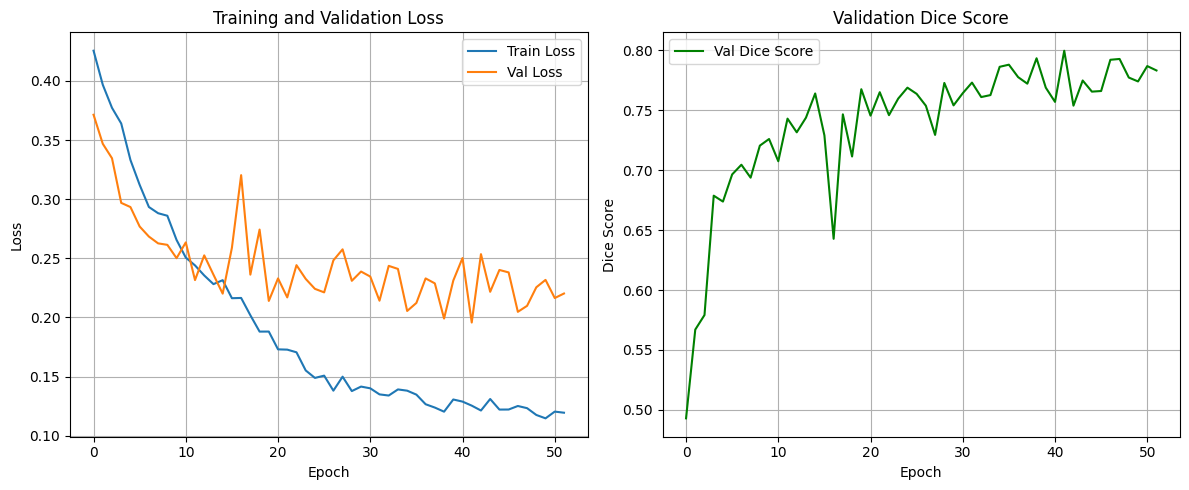

In [ ]:
# Plotting the training history
plt.figure(figsize=(12, 5))

# Plot Losses
plt.subplot(1, 2, 1)
plt.plot(range(0, len(train_loss_list)), train_loss_list, label='Train Loss')
plt.plot(range(0, len(train_loss_list)), val_loss_list, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Dice Score
plt.subplot(1, 2, 2)
plt.plot(range(0, len(train_loss_list)), val_dice_list, label='Val Dice Score', color='green')
plt.title('Validation Dice Score')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Results and Comments

### Base Model Definitions

#### Vanilla UNet

In [15]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[32, 64, 128, 256, 512]):
        super(UNet, self).__init__()

        # Downsampling path
        # Convolutional aggregation and pooling
        self.encoder = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        for feature in features:
            self.encoder.append(self.double_conv_block(in_channels, feature))
            in_channels = feature

        # Bottleneck
        # Double the feature map latent representation
        self.bottleneck = self.double_conv_block(features[-1], features[-1] * 2, 0.2)

        # Upsampling path
        # Convolution expansion and reconstruction
        self.upconv = nn.ModuleList()
        self.decoder = nn.ModuleList()

        for feature in reversed(features):
            self.upconv.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.decoder.append(self.double_conv_block(feature * 2, feature))

        # Final 1x1 convolution
        # Outputs binary mask
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Encoder
        # Store learned feature map for decoder to reference
        for down in self.encoder:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        # Decoder
        # Use stored feature map from encoder to reconstruct
        for i in range(len(self.upconv)):
            x = self.upconv[i](x)
            skip_connection = skip_connections[i]

            x = torch.cat((skip_connection, x), dim=1)
            x = self.decoder[i](x)

        # Output
        return self.final_conv(x)

    def double_conv_block(self, in_channels, out_channels, dropout_prob=0.4):
        # Simple double convolution block w/ ReLU activation
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=True),
            nn.GroupNorm(num_groups=8, num_channels=out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=True),
            nn.GroupNorm(num_groups=8, num_channels=out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout_prob)
        )


#### AGUNet

In [16]:
class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.GroupNorm(num_groups=8, num_channels=F_int),
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.GroupNorm(num_groups=8, num_channels=F_int),
        )

        # psi: Reduces intermediate features into a single attention map.
        #      Projects combined features from encoder-input + decoder-gate
        #      into a scalar attention logit per spatial location (element-wise).
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, g):
        # x: encoder features (long-skip connections)
        # g: decoder features (gating signal)

        g_out = self.W_g(g)
        x_out = self.W_x(x)

        psi = self.relu(g_out + x_out)
        alpha = self.psi(psi)

        return x * alpha  # element-wise attention
class AGUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[32, 64, 128, 256, 512], use_bilinear=False):
        super(AGUNet, self).__init__()

        # bilinear upsampling flag
        self.use_bilinear = use_bilinear

        # Downsampling path
        # Convolutional aggregation and pooling
        self.encoder = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        for feature in features:
            self.encoder.append(self.double_conv_block(in_channels, feature))
            in_channels = feature

        # Bottleneck
        # Double the feature map latent representation
        self.bottleneck = self.double_conv_block(features[-1], features[-1] * 2, 0.3)

        # Upsampling path
        # Convolution expansion and reconstruction
        # New: Attention Gates!
        self.upconv = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.attention_gates = nn.ModuleList()

        for feature in reversed(features):
            # Non-learnable bilinear interpolation upsampling
            if self.use_bilinear:
                self.upconv.append(
                    nn.Sequential(
                        nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                        nn.Conv2d(feature * 2, feature, kernel_size=1)  # project channels
                    )
                )
            # Learnable kernel-based upsampling
            else:
                self.upconv.append(
                    nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
                )

            # F_int is 0.5 * (number of feature maps)
            self.attention_gates.append(AttentionGate(F_g=feature, F_l=feature, F_int=feature // 2))

            self.decoder.append(self.double_conv_block(feature * 2, feature, 0.1))

        # Final 1x1 convolution
        # Outputs binary mask
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Encoder
        # Store learned feature map for decoder to reference
        for down in self.encoder:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        # Decoder
        # Use stored feature map from encoder to reconstruct
        for i in range(len(self.upconv)):
            x = self.upconv[i](x)
            skip_connection = skip_connections[i]

            # New: Apply attention gate
            attn_skip = self.attention_gates[i](skip_connection, x)

            # Concatenate attended skip with upsampled decoder features
            x = torch.cat((attn_skip, x), dim=1)
            x = self.decoder[i](x)

        # Output
        return self.final_conv(x)

    # Simple double convolution block w/ ReLU activation
    def double_conv_block(self, in_channels, out_channels, dropout_prob=0.0):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(num_groups=8, num_channels=out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(num_groups=8, num_channels=out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout_prob)
        )

### Best Model Type Comparison

#### Vanilla UNet

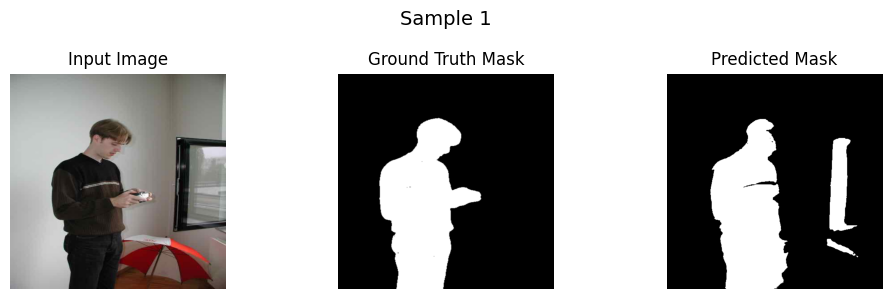

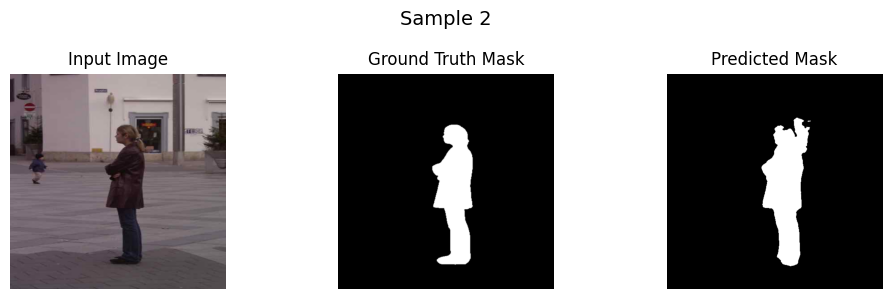

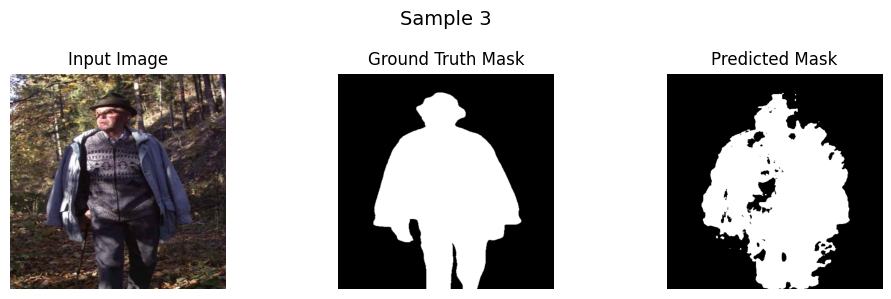

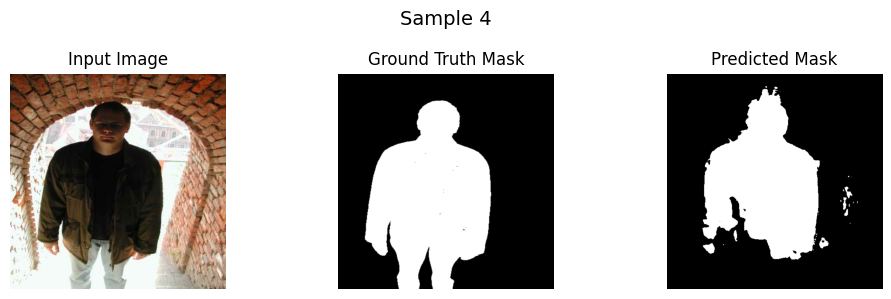

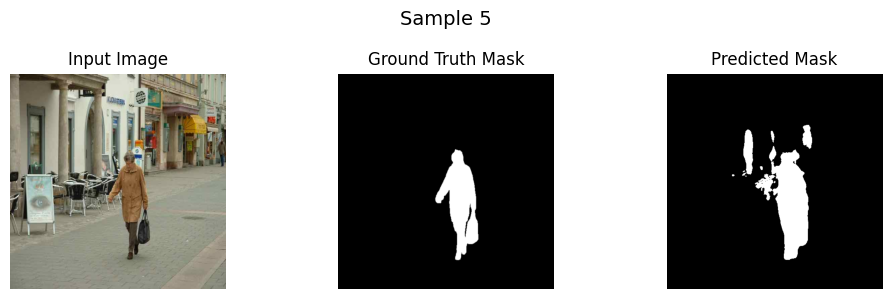

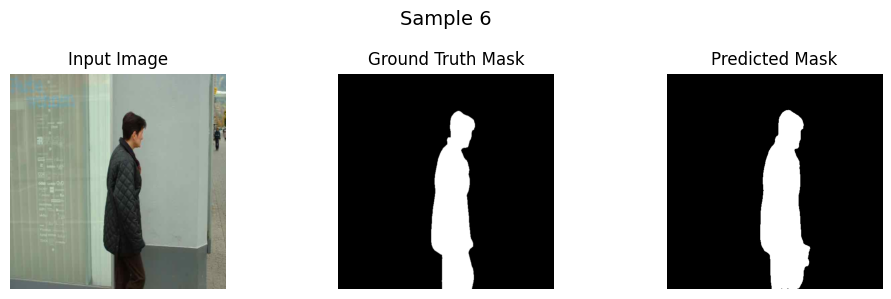

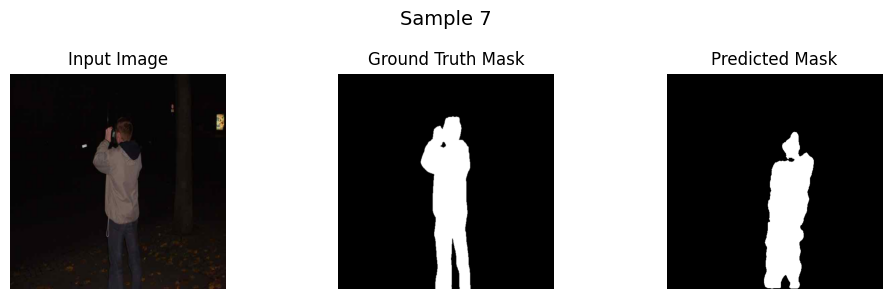

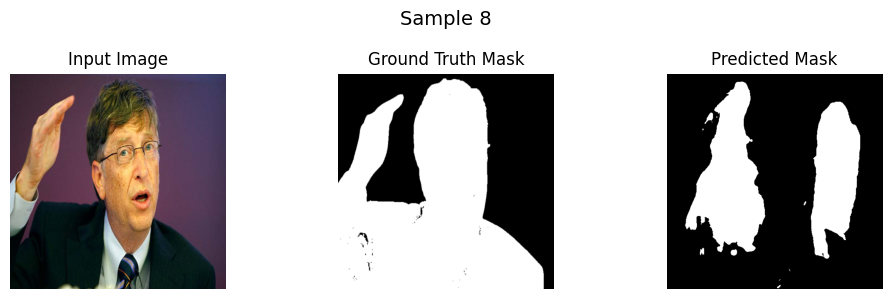

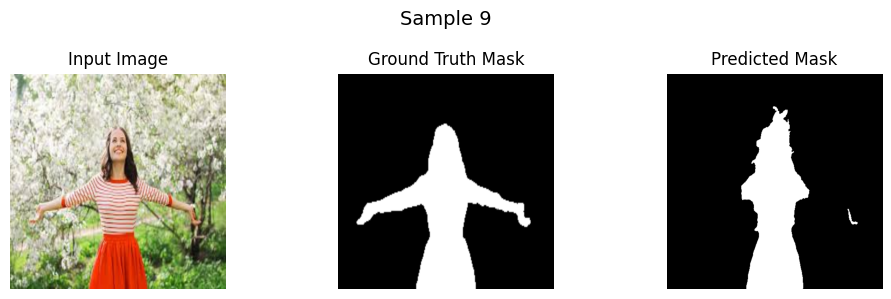

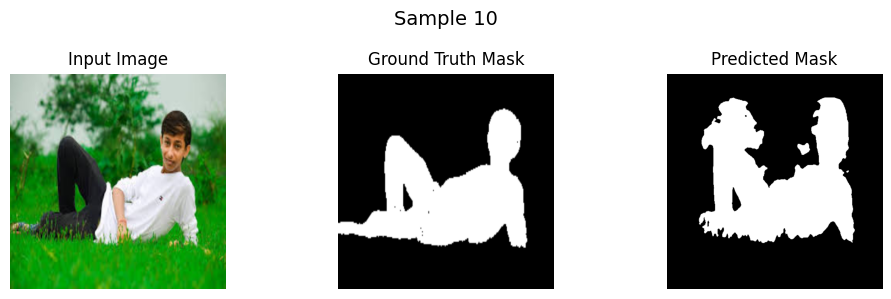

In [17]:
# Load best model checkpoint
checkpoint = torch.load("Model Checkpoints/best_unet_model.pt", map_location=device)

# Load model state
unet_model = UNet()
unet_model.to(device)
unet_model.load_state_dict(checkpoint['model_state_dict'])

# Run test!
run_test_and_visualize(unet_model, test_loader, device)

#### AGUNet

Num parameters: 31453174


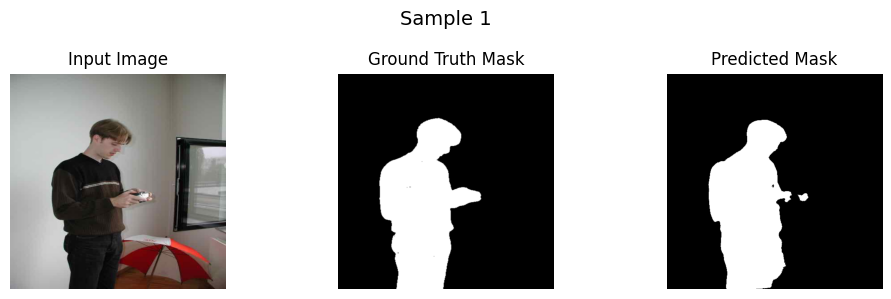

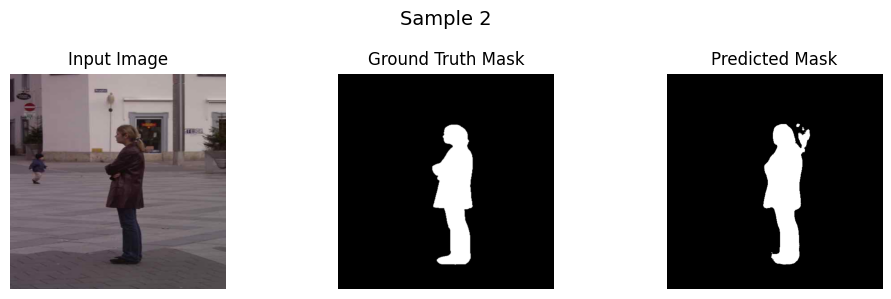

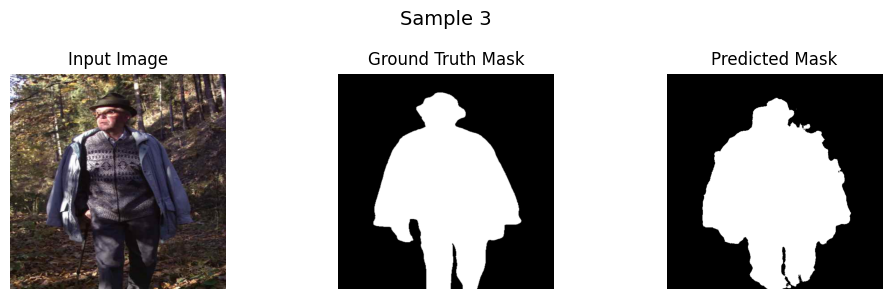

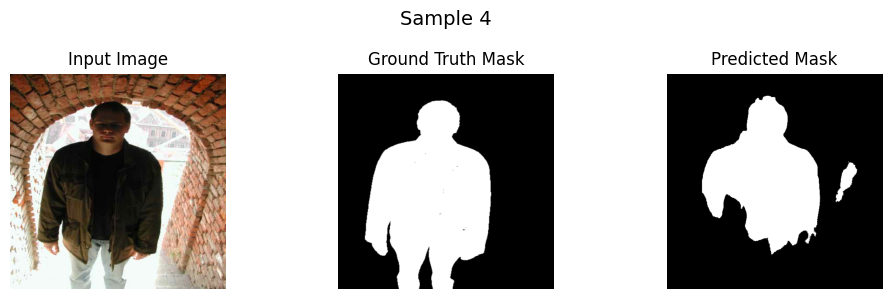

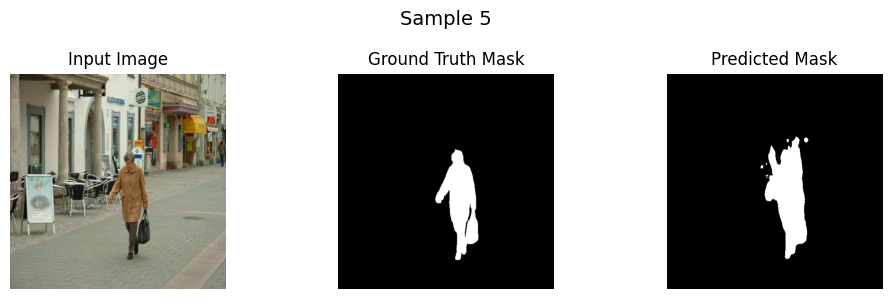

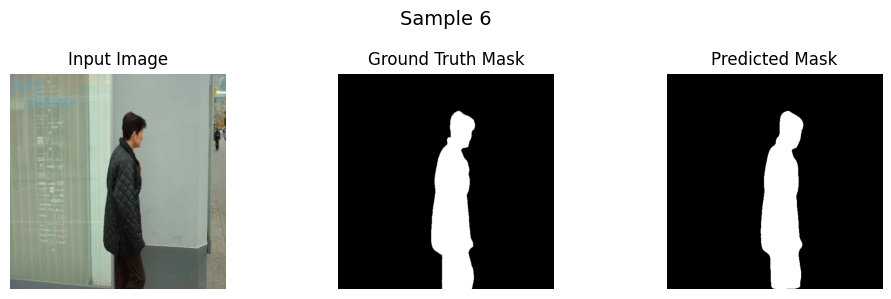

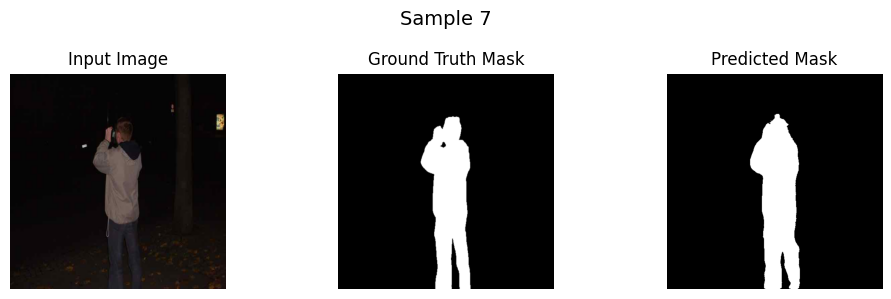

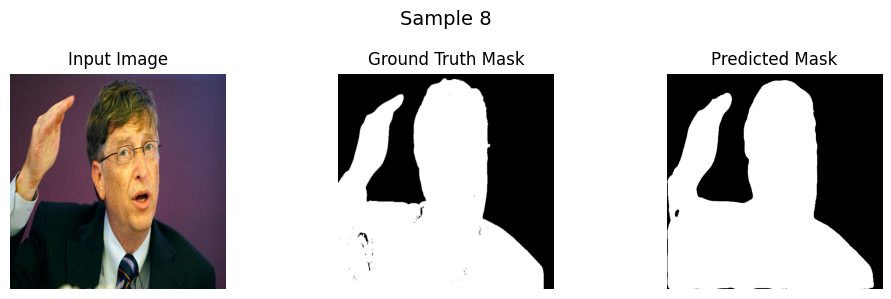

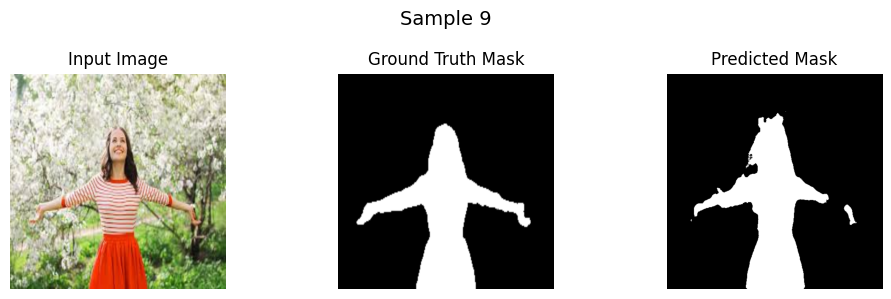

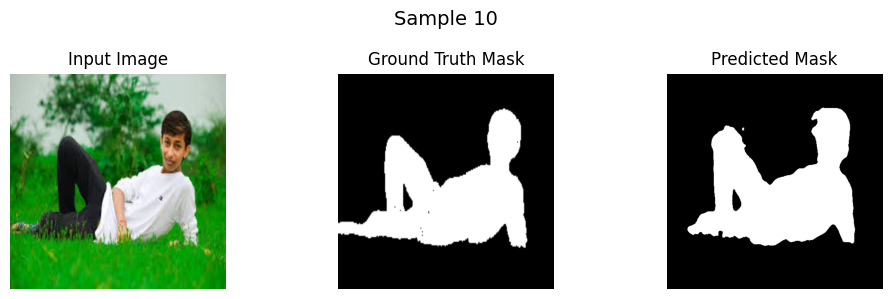

In [18]:
# Load best model checkpoint
checkpoint = torch.load("Model Checkpoints/best_agunet_model.pt", map_location=device)

# Load model state
agunet_model = AGUNet()
agunet_model.to(device)
agunet_model.load_state_dict(checkpoint['model_state_dict'])

# Run test!
print(f"Num parameters: {sum(p.numel() for p in agunet_model.parameters() if p.requires_grad)}")
run_test_and_visualize(agunet_model, test_loader, device)

#### RAGUNet

Num parameters: 32856022


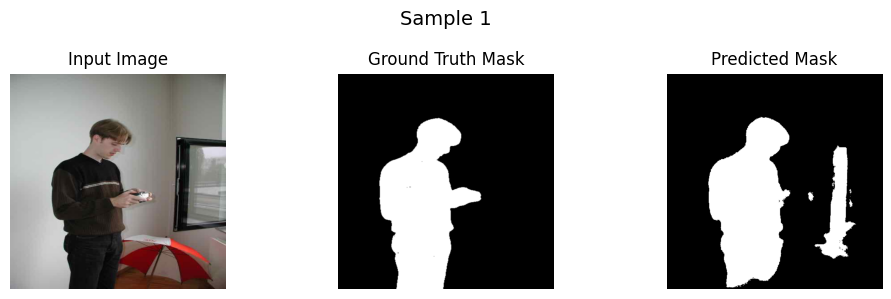

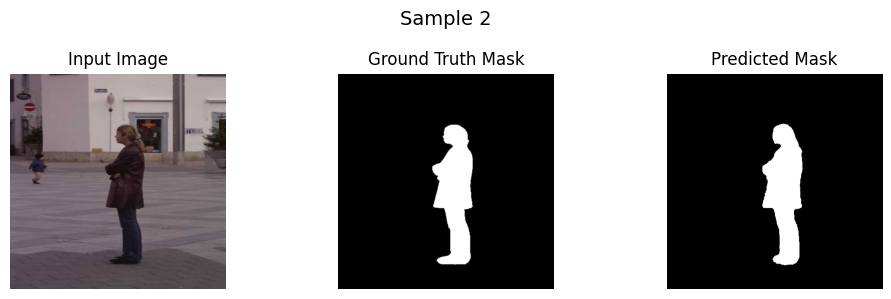

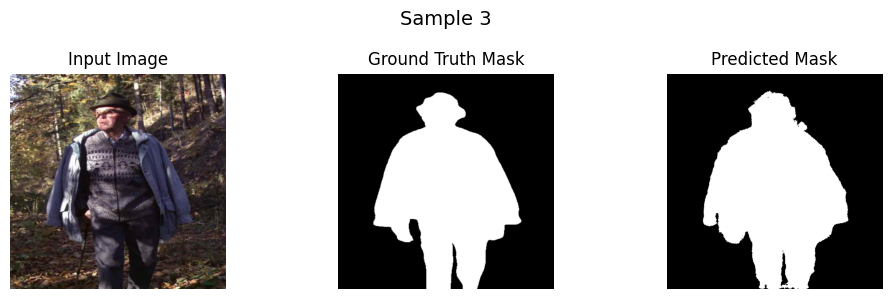

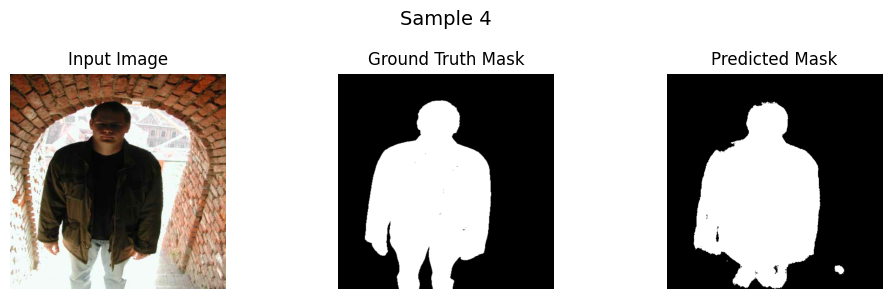

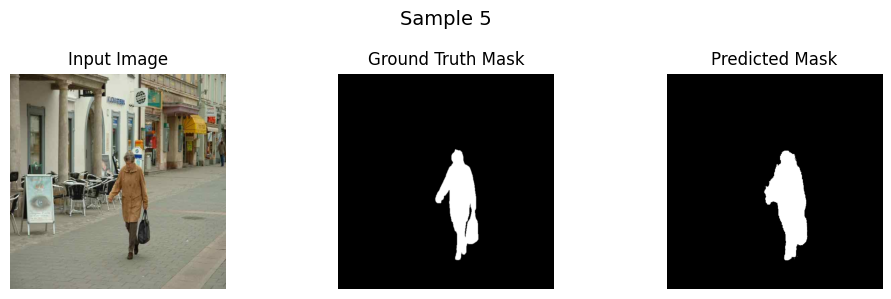

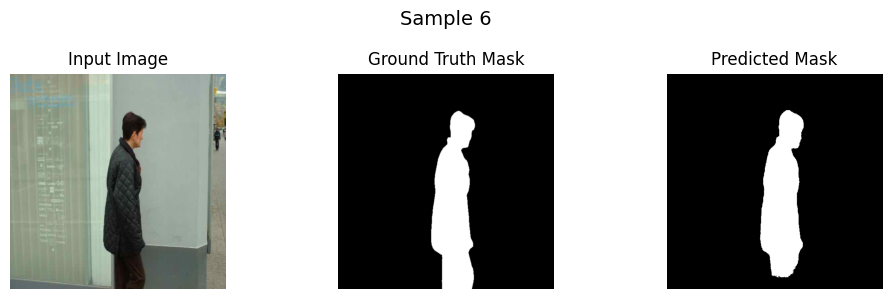

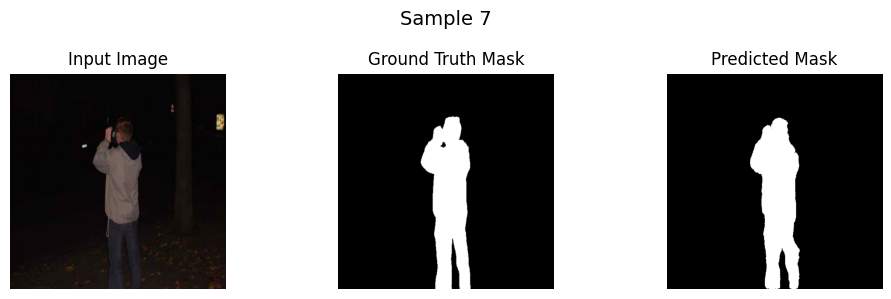

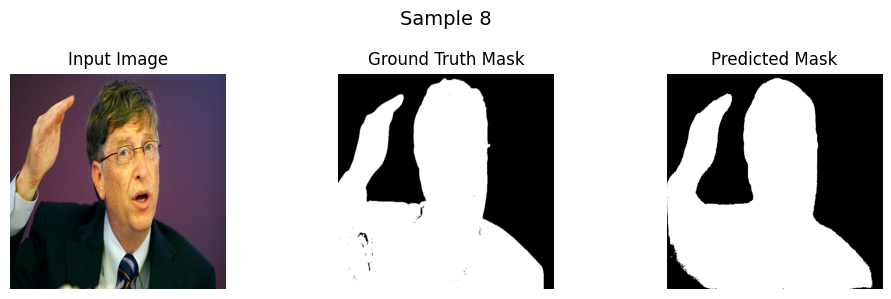

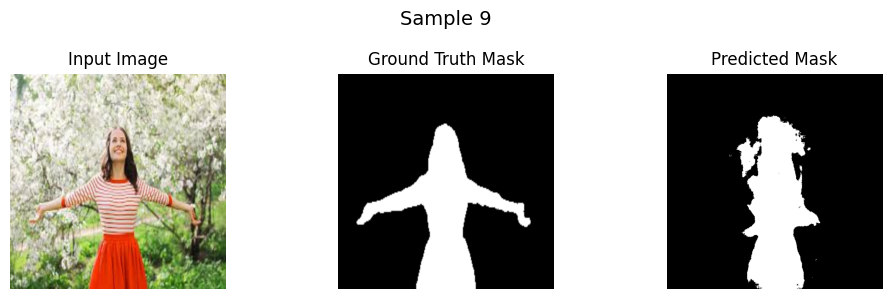

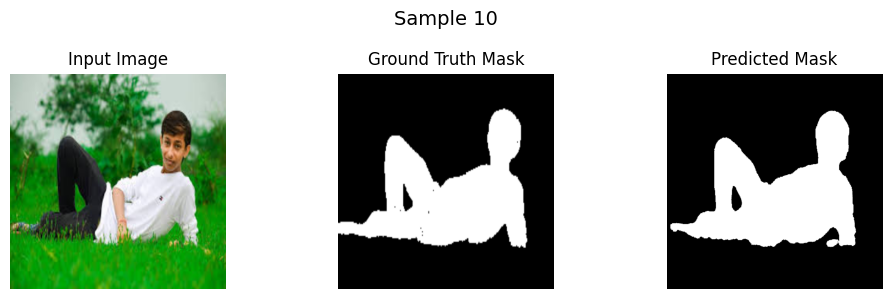

In [19]:
# Load best model checkpoint
checkpoint = torch.load("Model Checkpoints/best_ragunet_model.pt", map_location=device)

# Load model state
ragunet_model = RAGUNet()
ragunet_model.to(device)
ragunet_model.load_state_dict(checkpoint['model_state_dict'])

# Run test!
print(f"Num parameters: {sum(p.numel() for p in ragunet_model.parameters() if p.requires_grad)}")
run_test_and_visualize(ragunet_model, test_loader, device)

### Discussion

I spent about a week with each model, working as hard as I could to optimize, regularize, and push the limits with them. In the end, the models' performances on the test image set indicate empirically that:

1. Vanilla UNet
  - Has strong basic segmentation results. Most of the information necessary was appropriately captured.

2. AGUNet
  - Attention gates smoothed dice variation and increased smoothness of segmentation masks!

3. RAGUNet
  - Residual blocks helped to further smooth the segmentation masks, and helped the model identify rounded features of the human targets.

Further work on quantitative improvements of the models would be useful. Additionally, comparison with a SoTA model on its chosen dataset would be useful for benchmarking purposes, as low-shot human segmentation isn't all that common.

## Save Notebook as PDF

In [20]:
%%capture
!python -m pip install -U notebook-as-pdf
!pyppeteer-install
!sudo apt-get update
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic
!sudo apt-get install --reinstall texlive-xetex --fix-missing
!sudo apt-get install pandoc

In [21]:
!jupyter-nbconvert --to pdf RAGUNet.ipynb

[NbConvertApp] Converting notebook RAGUNet.ipynb to pdf
[NbConvertApp] Support files will be in RAGUNet_files/
[NbConvertApp] Making directory ./RAGUNet_files
[NbConvertApp] Writing 150649 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] CRITICAL | xelatex failed: ['xelatex', 'notebook.tex', '-quiet']
b'This is XeTeX, Version 3.141592653-2.6-0.999993 (TeX Live 2022/dev/Debian) (preloaded format=xelatex)\n restricted \\write18 enabled.\nentering extended mode\n(./notebook.tex\nLaTeX2e <2021-11-15> patch level 1\nL3 programming layer <2022-01-21>\n(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls\nDocument Class: article 2021/10/04 v1.4n Standard LaTeX document class\n(/usr/share/texlive/texmf-dist/tex/latex/base/size11.clo))\n(/usr/share/texlive/texmf-dist/tex/latex/tcolorbox/tcolorbox.sty\n(/usr/share/texlive/texmf-dist/tex/latex/pgf/basiclayer/pgf.sty\n(/usr/share/texlive/texmf-dist/t